# Equilibrium Propagation Demo

In [1]:
import argparse
import numpy
import torch

from datasets import load_dataloaders
from model.hopfield.network import DeepHopfieldEnergy
from model.function.network import Network
from model.function.cost import SquaredError
from model.hopfield.minimizer import FixedPointMinimizer
from training.sgd import EquilibriumProp, Backprop, AugmentedFunction
from training.epoch import Trainer, Evaluator
from training.monitor import Monitor, Optimizer

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

## Visualize Dataset

We will build and train a neural network composed of neurons arranged in one input layer, multiple hidden layers, and one output layer. The size (number of neurons) of the input layer depends on the size of example (numerical) data being presented to the network. In this demo, we'll use two-dimensional data from Scikit's Two Moons dataset - each 2D point in the dataset is associated with a binary label, 0 or 1.

Our Network will perform inference on 2D coordinate pairs; that is, given a specific (ordered) 2D point, it will decide whether the point belongs to class 0 or class 1. The input layer will have two indexed neurons, according to the size of the two-dimensional data. For a specifc (ordered) 2D point, the first input neuron will assume the value of the first coordinate, and the second input neuron will assume the value of the second coordinate. The two neurons in the input layer will be fixed to these values during inference.

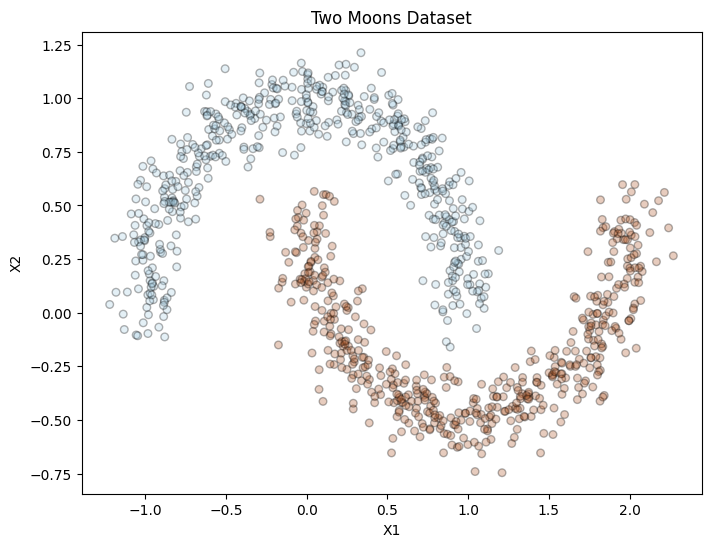

In [2]:
batch_size = 32
dataset = 'TwoMoons'
training_loader, test_loader = load_dataloaders(dataset, batch_size, augment_32x32=False, normalize=False)

X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=30, edgecolor='k', alpha=0.3)
plt.title("Two Moons Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# Output of the Network

There are two classes, 0 or 1, in our classification task. Ater performing inference on a specific input 2D point, the values of the network's output neurons will be interpreted as probabilities (After softmaxing) that the input point belongs to the respective classes. Therefore, our neural network will have two output neurons, one representing class 0, and the other representing class 1. 

In [3]:
num_hidden_layers = 2
num_neurons = 1024

model = 'dhn-'+str(num_hidden_layers)+'h'

layer_shapes = []
layer_shapes.append((2,))
for i in range(num_hidden_layers):
    layer_shapes.append((num_neurons,))
layer_shapes.append(( 2,))

In [10]:
num_iterations_inference = 50
num_iterations_training = 20
nudging = 0.2
num_epochs = 100

In [11]:
weight_init_dist = 'xavier_normal'
weight_gains = [1.0] * (num_hidden_layers+1)
learning_rates_weights = list(np.linspace(0.2, 0.01, num_hidden_layers+1))
learning_rates_biases = list(np.linspace(0.2, 0.01, num_hidden_layers+1))

In [12]:
energy_fn = DeepHopfieldEnergy(layer_shapes, weight_gains, weight_init_dist)
if torch.cuda.is_available(): device = "cuda"
else: device = "cpu"
energy_fn.set_device(device)

output_layer = energy_fn.layers()[-1]
cost_fn = SquaredError(output_layer)

network = Network(energy_fn)

In [13]:
params = energy_fn.params()
layers = energy_fn.layers()
free_layers = network.free_layers()

In [14]:
augmented_fn = AugmentedFunction(energy_fn, cost_fn)
energy_minimizer_training = FixedPointMinimizer(augmented_fn, free_layers)
estimator = EquilibriumProp(params, layers, augmented_fn, cost_fn, energy_minimizer_training)
estimator.nudging = nudging
estimator.variant = 'centered'

energy_minimizer_training.num_iterations = num_iterations_training
energy_minimizer_training.mode = 'asynchronous'

learning_rates = learning_rates_biases + learning_rates_weights
momentum = 0.
weight_decay = 0. * 1e-4
optimizer = Optimizer(energy_fn, cost_fn, learning_rates, momentum, weight_decay)

energy_minimizer_inference = FixedPointMinimizer(energy_fn, free_layers)
energy_minimizer_inference.num_iterations = num_iterations_inference
energy_minimizer_inference.mode = 'asynchronous'

trainer = Trainer(network, cost_fn, params, training_loader, estimator, optimizer, energy_minimizer_inference)
evaluator = Evaluator(network, cost_fn, test_loader, energy_minimizer_inference)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
path = '/'.join(['papers/fast-drn', model, 'EP'])
monitor = Monitor(energy_fn, cost_fn, trainer, scheduler, evaluator, path)

print('Dataset: {} -- batch_size={}'.format(dataset, batch_size))
print('Network: ', energy_fn)
print('Cost function: ', cost_fn)
print('Energy minimizer during inference: ', energy_minimizer_inference)
print('Energy minimizer during training: ', energy_minimizer_training)
print('Gradient estimator: ', estimator)
print('Parameter optimizer: ', optimizer)
print('Number of epochs = {}'.format(num_epochs))
print('Path = {}'.format(path))
print('Device = {}'.format(device))
print()

Dataset: TwoMoons -- batch_size=32
Network:  Deep Hopfield Network -- layer shapes=[(2,), (1024,), (1024,), (2,)], weight gains=[1.0, 1.0, 1.0]
Cost function:  Squared Error (MSE)
Energy minimizer during inference:  Fixed point minimizer -- mode=asynchronous, num_iterations=50
Energy minimizer during training:  Fixed point minimizer -- mode=asynchronous, num_iterations=20
Gradient estimator:  Equilibrium propagation -- mode=centered, nudging=0.2, formula=standard
Parameter optimizer:  SGD -- initial learning rates = [np.float64(0.2), np.float64(0.10500000000000001), np.float64(0.01), np.float64(0.2), np.float64(0.10500000000000001), np.float64(0.01)], momentum=0.0, weight_decay=0.0
Number of epochs = 100
Path = papers/fast-drn/dhn-2h/EP
Device = cpu



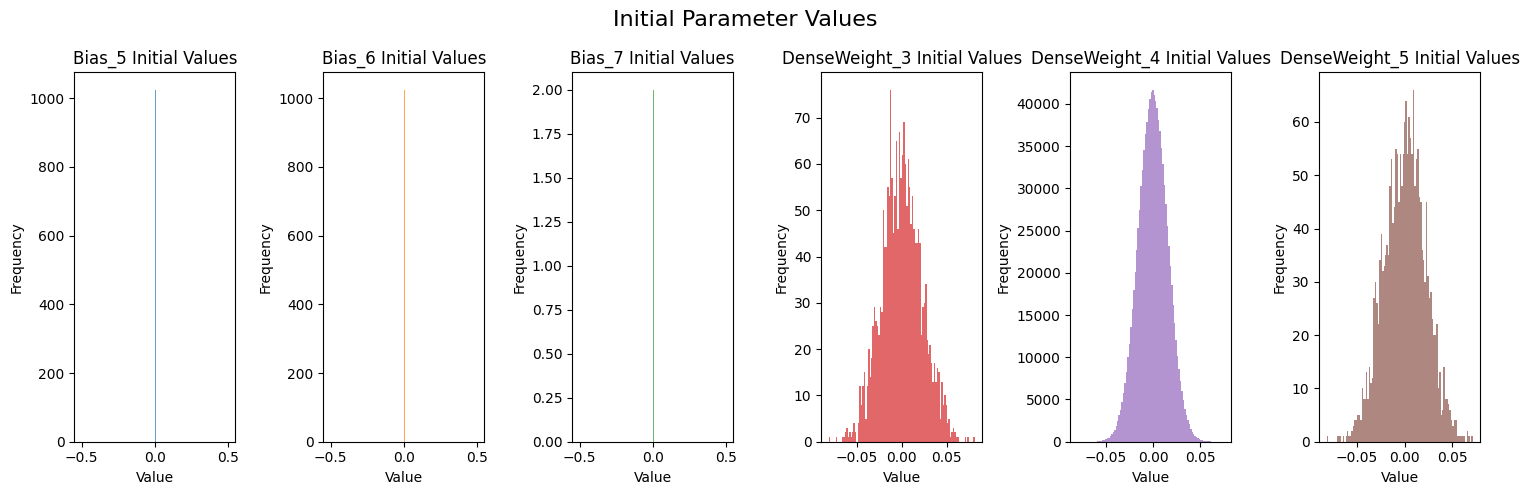

In [15]:
tensors = []
tensor_names = []

for p in energy_fn.params():
    tensor_names.append(p.name)
    tensors.append(p.get())

fig, axes = plt.subplots(1, len(tensors), figsize=(15, 5))
for i, (tensor, ax) in enumerate(zip(tensors, axes)):
    if tensor.ndim > 1:
        tensor = tensor.flatten()
    ax.hist(tensor.numpy(), bins=100, alpha=0.7, color=f"C{i}")
    ax.set_title(tensor_names[i] + ' Initial Values')
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
fig.suptitle('Initial Parameter Values', fontsize=16)
# Adjust layout
plt.tight_layout()
plt.show()

In [16]:
# Launch the Experiment
monitor.run(num_epochs, verbose=True)

Epoch 1
TRAIN -- Example  8000/8000, Energy = -6.10, Cost = 0.09382, Error = 11.338%, Top5Error = 0.000%
TEST  -- Example  2000/2000, Energy = -7.34, Cost = 0.04750, Error = 5.300%, Top5Error = 0.000%
Duration = 0 hours 0 min 23 sec 

Epoch 2
TRAIN -- Example  8000/8000, Energy = -8.88, Cost = 0.03618, Error = 3.625%, Top5Error = 0.000%
TEST  -- Example  2000/2000, Energy = -10.76, Cost = 0.00178, Error = 0.000%, Top5Error = 0.000%
Duration = 0 hours 0 min 39 sec 

Epoch 3
TRAIN -- Example  8000/8000, Energy = -10.63, Cost = 0.00120, Error = 0.025%, Top5Error = 0.000%
TEST  -- Example  2000/2000, Energy = -10.82, Cost = 0.00039, Error = 0.000%, Top5Error = 0.000%
Duration = 0 hours 0 min 56 sec 

Epoch 4
TRAIN -- Example  8000/8000, Energy = -10.65, Cost = 0.00061, Error = 0.025%, Top5Error = 0.000%
TEST  -- Example  2000/2000, Energy = -10.89, Cost = 0.00017, Error = 0.000%, Top5Error = 0.000%
Duration = 0 hours 1 min 12 sec 

Epoch 5
TRAIN -- Example  8000/8000, Energy = -10.70, Cost

In [17]:
hidden_layers = network.free_layers()
hidden_layer_names = []
for layer in hidden_layers:
    hidden_layer_names.append(layer.name)

print(hidden_layer_names)

['Layer_5', 'Layer_6', 'Layer_7']


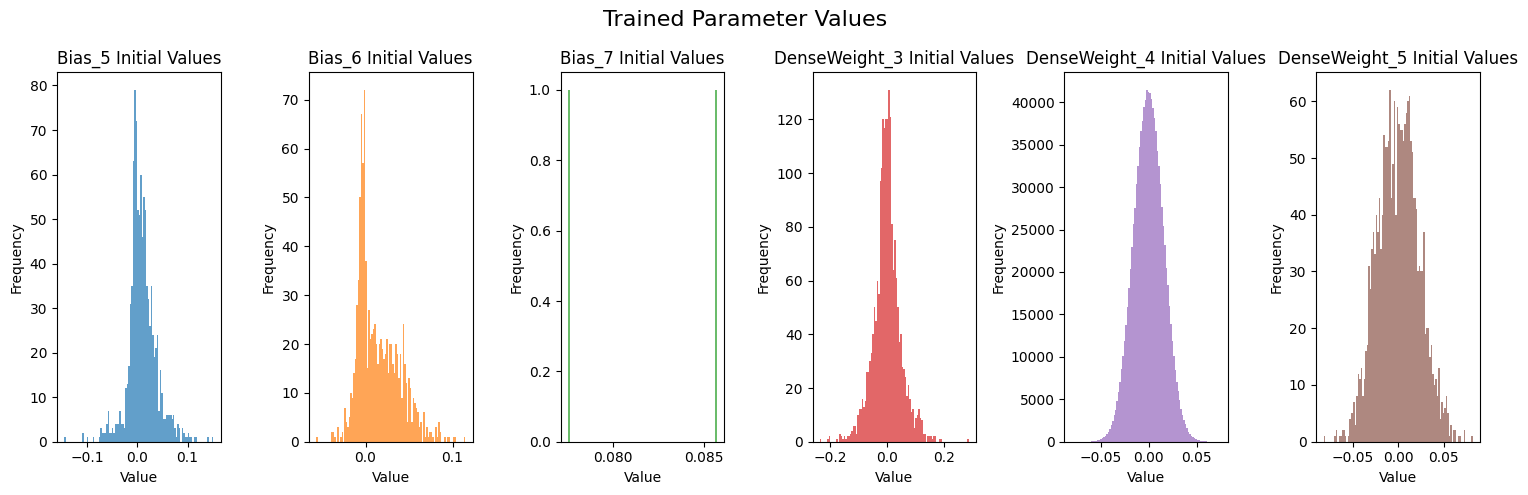

In [18]:
tensors = []
tensor_names = []

for p in energy_fn.params():
    tensor_names.append(p.name)
    tensors.append(p.get())

fig, axes = plt.subplots(1, len(tensors), figsize=(15, 5))
for i, (tensor, ax) in enumerate(zip(tensors, axes)):
    if tensor.ndim > 1:
        tensor = tensor.flatten()
    ax.hist(tensor.numpy(), bins=100, alpha=0.7, color=f"C{i}")
    ax.set_title(tensor_names[i] + ' Initial Values')
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
fig.suptitle('Trained Parameter Values', fontsize=16)
# Adjust layout
plt.tight_layout()
plt.show()

In [31]:
batch_ind = 3


iotum_dict = {}
neuron_dict = {}

for layer in hidden_layer_names:
        iotum_dict[layer] = []
        neuron_dict[layer] = []



for k, (x, y, idx) in enumerate(test_loader):
        if k == batch_ind:
                batch = x
                batch_labels = y
                network.set_input(batch, reset=True)
                traj = energy_minimizer_inference.compute_trajectory()
                for layer in hidden_layer_names:
                        batch_vals = torch.stack(traj[layer], dim=0)
                        clamped_vals = torch.clamp(batch_vals, min=0.0, max=1.0)
                        print(layer, batch_vals.shape, clamped_vals.shape)
                        iotum_dict[layer] = batch_vals * clamped_vals
                        neuron_dict[layer] = batch_vals

Layer_5 torch.Size([101, 32, 1024]) torch.Size([101, 32, 1024])
Layer_6 torch.Size([101, 32, 1024]) torch.Size([101, 32, 1024])
Layer_7 torch.Size([101, 32, 2]) torch.Size([101, 32, 2])


In [32]:
print(iotum_dict['Layer_5'])

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[2.9661e-04, 4.2793e-04, 2.7013e-03,  ..., 1.8902e-03,
          3.6452e-06, 1.1850e-04],
         [1.7671e-04, 1.9197e-04, 5.5175e-03,  ..., 7.4861e-04,
          6.1759e-06, 4.3795e-05],
         [4.5396e-04, 7.6316e-04, 5.8741e-03,  ..., 2.0672e-03,
          0.0000e+00, 0.0000e+00],
         ...,
         [3.3099e-05, 4.8987e-07, 1.7028e-02,  ..., 0.0000e+00,
          0.000

INPUT COORDINATES: [0.0862755  0.98803985]
CLASS PROBABILITIES: [0.00094162 0.00093778 0.00113317 ... 0.00093778 0.00099428 0.00093778]


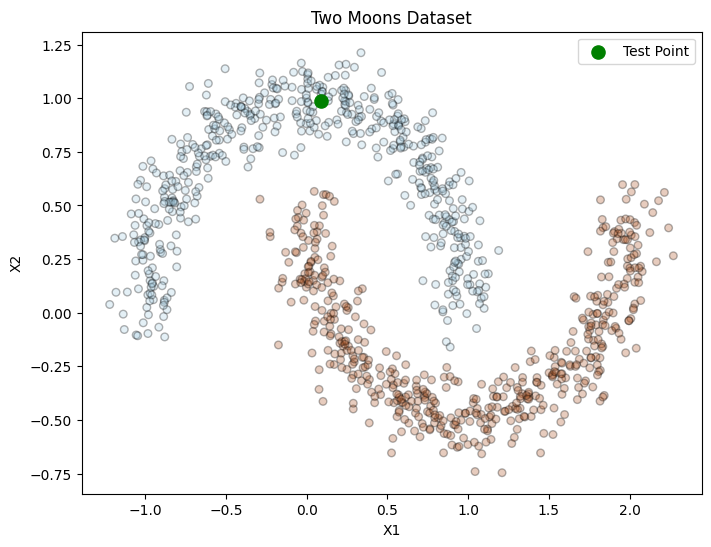

In [33]:
time_stp = -1
ind = 10

test_point = batch.numpy()[ind,:]
print('INPUT COORDINATES:', test_point)
output_vals = neuron_dict['Layer_5'][-1,ind,:]
output_probs = torch.nn.functional.softmax(output_vals, dim=0).numpy()
print('CLASS PROBABILITIES:', output_probs)

X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=30, edgecolor='k', alpha=0.3)
plt.title("Two Moons Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(test_point[0], test_point[1], c='green', s=90, label='Test Point')
plt.legend()
plt.show()

tensor([-0.0219,  1.0409])


tensor([0.2568, 0.7432])

(array([18., 17., 11., 21.,  9.,  5., 14., 13.,  6.,  6., 13.,  8., 11.,
         3.,  3.,  9.,  5.,  1.,  7.,  4.,  2.,  3.,  1.,  4.,  3.,  5.,
         3.,  8.,  4.,  2.,  5.,  3.,  5.,  1.,  3.,  2.,  3.,  1.,  4.,
         4.,  1.,  3.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,  0.,  0.,  2.,
         0.,  2.,  0.,  1.,  4.,  3.,  1.,  2.,  0.,  2.,  1.,  1.,  0.,
         0.,  1.,  0.,  2.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  2.,
         1.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

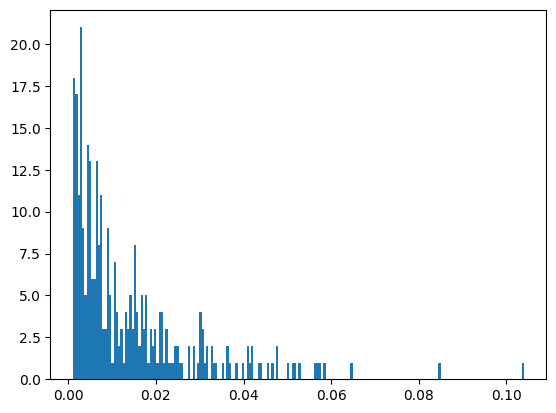

In [41]:
time_stp = -1
ind = 10

vals = iotum_dict['Layer_6'].numpy()[time_stp, ind, :]
hist_vals = []
for val in vals:
    if val > 1e-3:
        hist_vals.append(val)
hist_vals = np.array(hist_vals)
plt.hist(hist_vals, bins=200)
#plt.xlim(0,0.04)


In [ ]:
ind = 10

vals = iotum_dict['Layer_2'][-1,ind,:]
print(np.shape(vals))
hist_vals = []
for val in vals:
    if val > 1e-4:
        hist_vals.append(val)
hist_vals = np.array(hist_vals)

plt.hist(hist_vals, bins=300)

In [ ]:
network.set_input(batch, reset=True)
eq = energy_minimizer_inference.compute_equilibrium()
print(eq['Layer_1'].shape)

In [ ]:

iotum_traj = []

network.set_input(batch, reset=True)
traj = energy_minimizer_inference.compute_trajectory()
for st in traj['Layer_1']:
    clamped_st = torch.clamp(st, min=0.0, max=1.0)
    iotum_traj.append((st * clamped_st).numpy())


In [ ]:
batch_ind = 12

final_iotum = iotum_traj[1][batch_ind,:]

plt.hist(final_iotum[final_iotum != 0.0], bins=100)
plt.xlim(0, 0.1)

In [ ]:
batch_ind = 12

final_iotum = iotum_traj[-1][batch_ind,:]

plt.hist(final_iotum[final_iotum != 0.0], bins=100)
plt.xlim(0, 0.1)